<a href="https://colab.research.google.com/github/LI3ARA/FYIRP/blob/main/Notebooks/25/VQA_RAG/Googl_colab/soft_prompting/downloading_data_and_formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!nvidia-smi

Thu May  1 09:24:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P0             29W /   72W |   18447MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installations

Install and restart the runtime

In [2]:
!pip3 install bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [92]:
!pip install accelerate

In [112]:
import gc
import torch

# Delete model, processor, trainer explicitly
# del model
# del processor
# del trainer

# Collect garbage and empty CUDA cache
gc.collect()
torch.cuda.empty_cache()


In [111]:
# Reset CUDA memory stats (safe, not required but helpful)
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.reset_accumulated_memory_stats()

In [1]:
import os
# os.environ['WANDB_DISABLED'] = "false"

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor, LlavaForConditionalGeneration

In [4]:
from transformers import AutoModelForCausalLM

In [5]:
# from datasets import load_dataset
# import torch
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig, TrainingArguments # Bitsandbytesconfig for fit the model for gpu
from peft import LoraConfig, get_peft_model #LoRA adapter usage is made possible by these
from trl import SFTTrainer, SFTConfig

In [6]:
from transformers import AutoTokenizer, AutoProcessor

In [7]:
from trl import (
    ModelConfig,
    ScriptArguments,
    SFTConfig,
    SFTTrainer,
    TrlParser,
    get_kbit_device_map,
    get_peft_config,
    get_quantization_config,
)

In [8]:
import json

In [9]:
from PIL import Image

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# MODEL_ID = "liuhaotian/llava-v1.5-7b"

In [12]:
EPOCHS = 1
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True # Standar bp store intermediate activations, speeds up gpu process, instr=ead of storing it is recaluculated
USE_REENTRANT = True
OPTIM = 'paged_adamw_32bit'
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50 #how many steps the logging happens for training and validation

In [13]:
EVAL_STEPS = 50
SAVE_STEPS = 50
DATASET_SIZE = 568
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True} # We have to put for VLMs # have to do preparation manually
REMOVE_UNUSED_COLUMNS = False # VLM thing
MAX_SEQ_LEN=128 #output max length
NUM_STEPS = (DATASET_SIZE // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

NUM_STEPS: 568


## Loading the datasets

#### Full train dataset

In [14]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json",'r') as f:
  dataset_train_json_full = json.load(f)

In [15]:
dataset_train_json_full[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [16]:
len(dataset_train_json_full)

262524

In [17]:
import random
import json

# Assume `all_data` is your full list of 26,000 examples
# Example: all_data = json.load(open("spiqa_train.json"))

# Set random seed for reproducibility
random.seed(42)

# Select 2,000 random but consistent examples
dataset_subset = random.sample(dataset_train_json_full, 2000)

# Optional: Save to JSON if needed
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_train_subset_2000.json", "w") as f:
    json.dump(dataset_subset, f, indent=2)


In [18]:
dataset_subset[0]

{'id': '1911.01655v1',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1911.01655v1/1911.01655v1-Figure5-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nHow does the performance of the different models compare in terms of Peak Signal-to-Noise Ratio?'},
  {'from': 'gpt',
   'value': 'The CNN Best FVD model performs the best, followed by the LSTM Best FVD model, and then the SVG Best FVD model.'}]}

In [19]:
def convert_conversations(entry):
    new_conv = []
    for turn in entry["conversations"]:
        role = "user" if turn["from"] == "human" else "assistant"
        text = turn["value"].replace("<image>", "").strip()
        blocks = [{"type": "text", "text": text}]
        if "<image>" in turn["value"]:
            blocks.insert(0, {"type": "image"})
        new_conv.append({"role": role, "content": blocks})
    return {
        "id": entry["id"],
        "images": [entry["image"]],
        "messages": new_conv
    }


In [20]:
dataset = [convert_conversations(e) for e in dataset_subset]


In [21]:
dataset[0]

{'id': '1911.01655v1',
 'images': ['/content/spiqa/spiqa_images/SPIQA_train_val_Images/1911.01655v1/1911.01655v1-Figure5-1.png'],
 'messages': [{'role': 'user',
   'content': [{'type': 'image'},
    {'type': 'text',
     'text': 'How does the performance of the different models compare in terms of Peak Signal-to-Noise Ratio?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The CNN Best FVD model performs the best, followed by the LSTM Best FVD model, and then the SVG Best FVD model.'}]}]}

In [61]:
sample = dataset[0]
prompt = processor.apply_chat_template(sample["messages"], tokenize=False)
print(prompt)


USER: <image>
How does the performance of the different models compare in terms of Peak Signal-to-Noise Ratio? ASSISTANT: The CNN Best FVD model performs the best, followed by the LSTM Best FVD model, and then the SVG Best FVD model. 


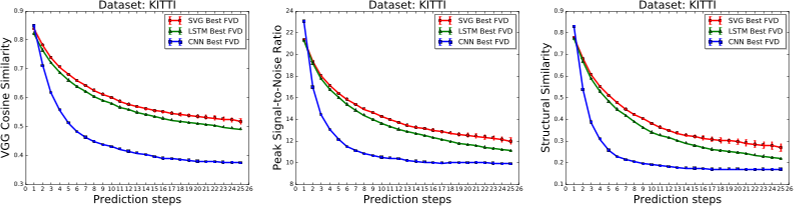

In [63]:
# process image and text
from PIL import Image

# Load image
image = Image.open(sample["images"][0]).convert("RGB")
image

In [64]:
# Process input correctly
inputs = processor(images=image, text=prompt, return_tensors="pt")

# Labels for training
labels = inputs["input_ids"].clone()
labels[labels == processor.tokenizer.pad_token_id] = -100
inputs["labels"] = labels

# Sanity check
print(inputs.keys())  # Expected: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])


In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_train.json",'r') as f:
  dataset_train_json_orignal = json.load(f)

In [110]:
dataset_train_json_orignal['2306.14859v1']

NameError: name 'dataset_train_json_orignal' is not defined

In [ ]:
# testing converstion
import os

# Example input data
entry = {
    'paper_id': '2306.14859v1',
    'all_figures': {
        '2306.14859v1-Figure1-1.png': {
            'caption': ' Dimensionality estimates of images obtained using the MLE method with k nearest neighbors under different sample size.',
            'content_type': 'figure',
            'figure_type': 'plot'
        }
    },
    'qa': [
        {
            'question': 'What is the effect of increasing the sample size on the dimensionality estimate?',
            'answer': 'The dimensionality estimate increases as the sample size increases.',
            'explanation': 'The figure shows that the dimensionality estimate increases as the sample size increases. This is because, with a larger sample size, there is more data to learn from, and the model can better estimate the true dimensionality of the data.',
            'reference': '2306.14859v1-Figure1-1.png'
        }
    ]
}

# You can change this to your actual image directory path
image_dir = "/your/image/directory"

# Extract image path
image_filename = entry['qa'][0]['reference']
image_path = os.path.join(image_dir, image_filename)

# Construct messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": entry['qa'][0]['question']},
            {"type": "image"}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": entry['qa'][0]['answer']}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Can you explain why?"}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": entry['qa'][0]['explanation']}
        ]
    }
]

# Final format
output = {
    "images": [image_path],
    "messages": messages
}
output

{'images': ['/your/image/directory/2306.14859v1-Figure1-1.png'],
 'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'What is the effect of increasing the sample size on the dimensionality estimate?'},
    {'type': 'image'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The dimensionality estimate increases as the sample size increases.'}]},
  {'role': 'user',
   'content': [{'type': 'text', 'text': 'Can you explain why?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The figure shows that the dimensionality estimate increases as the sample size increases. This is because, with a larger sample size, there is more data to learn from, and the model can better estimate the true dimensionality of the data.'}]}]}

In [ ]:
import os
import json

# Set your actual image directory path here
# image_dir = "./figures"

# The dataset dictionary you provided
def covert_to_conversational(dataset_train_json_orignal):
# dataset_train_json_orignal = {
    #     # ... your full dataset ...
    # }

    converted_dataset = []

    for paper_id, entry in dataset_train_json_orignal.items():
        all_figures = entry.get("all_figures", {})
        qa_pairs = entry.get("qa", [])

        for qa in qa_pairs:
            reference_image = qa.get("reference")
            if not reference_image or reference_image not in all_figures:
                continue  # skip if reference is missing or invalid

            image_path = reference_image #os.path.join(image_dir, reference_image)

            question = qa.get("question", "")
            answer = qa.get("answer", "")
            explanation = qa.get("explanation", "")

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": question},
                        {"type": "image"}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]

            # Optionally add explanation if available
            if explanation:
                messages.append({
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Can you explain why?"}
                    ]
                })
                messages.append({
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": explanation}
                    ]
                })

            converted_dataset.append({
                "images": [image_path],
                "messages": messages
            })

    # Optionally: save to a file
    with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/LLAVA_fine_tuning/converted_dataset_train_spiqa_conversational.json", "w") as f:
        json.dump(converted_dataset, f, indent=2)


In [ ]:
covert_to_conversational(dataset_train_json_orignal)

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/LLAVA_fine_tuning/converted_dataset_train_spiqa_conversational.json", "r") as f:
        converted_conversational_train = json.load(f)

In [ ]:
converted_conversational_train[0]

{'images': ['1612.01810v3-Figure6-1.png'],
 'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Which method converges faster, joint or separate assignment and update steps?'},
    {'type': 'image'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The joint method converges faster than the separate method.'}]},
  {'role': 'user',
   'content': [{'type': 'text', 'text': 'Can you explain why?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The figure shows the boundary recall of the two methods over the number of iterations. The joint method (red line) reaches a higher boundary recall in fewer iterations than the separate method (blue line).'}]}]}

#### Apply chat template

##### Testing on a sample

In [109]:
# Testing on the train sample
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf",torch_dtype=torch.bfloat16)
print(processor.apply_chat_template(messages, tokenize=False))

NameError: name 'messages' is not defined

In [ ]:
processor.apply_chat_template(converted_conversational_train[0]['messages'], tokenize=False)

'USER: <image>\nWhich method converges faster, joint or separate assignment and update steps? ASSISTANT: The joint method converges faster than the separate method. USER: Can you explain why? ASSISTANT: The figure shows the boundary recall of the two methods over the number of iterations. The joint method (red line) reaches a higher boundary recall in fewer iterations than the separate method (blue line). '

##### Trying on the train dataset

In [ ]:
!os.chdir("LLaVA")

/bin/bash: -c: line 1: syntax error near unexpected token `"LLaVA"'
/bin/bash: -c: line 1: `os.chdir("LLaVA")'


## final dataset format

In [ ]:
system_message = """You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data.
Your task is to process and extract meaningful insights from images, videos, and visual patterns,
leveraging multimodal understanding to provide accurate and contextually relevant information."""

def format_data(sample):
    return [
        {# Fisry dictionary
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {# second disctionary
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": Image.open(sample['image']).convert("RGB"),
                },
                {
                    "type": "text",
                    "text": sample["conversations"][0]['value'],
                },
            ],
        },
        {# third dictionary
            "role": "assistant",
            "content": [{"type": "text", "text": sample["conversations"][1]['value']}],
        },
    ]

In [ ]:
# Load the original json files to convert to lora_intermediate format
def convert_to_lora_intermediate_dataset(spiqa_data, image_base_path = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"):
  converted = []
  image_base_path =  image_base_path # Where the images were extracted

  # Iterate through each paper
  for paper_id, paper in spiqa_data.items():
      figures = paper.get("all_figures", {})
      qa_pairs = paper.get("qa", [])

      # print("Nu of qa pairs:", (qa_pairs))

      for qa in qa_pairs:
          ref_img = qa.get("reference")
          question = qa.get("question")
          answer = qa.get("answer")

          if not ref_img or ref_img not in figures:
              continue

          image_path = os.path.join(image_base_path, paper_id, ref_img)
          if not os.path.exists(image_path):
            # print('path does not exist', image_path)
            continue

          # Add to LLaVA-style format
          converted.append({
              "id": paper_id,
              "image": image_path,
              "conversations": [
                  {
                      "from": "human",
                      "value": f"<image>\n{question}"
                  },
                  {
                      "from": "gpt",
                      "value": answer
                  }
              ]
          })
  return converted


### Loading the LoRA structured training dataset

In [15]:
from huggingface_hub import snapshot_download

# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [16]:
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [17]:
zip_path = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/test-A/SPIQA_testA_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### training dataset

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_sample.json", "r") as f:
    dataset_train_json = json.load(f)

In [ ]:
len(dataset_train_json)

2000

In [ ]:
dataset_train_json[0]

{'id': '1909.07623v1',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1909.07623v1/1909.07623v1-Figure8-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nHow does the DEAR + RGB image compare to the ToF depth + RGB image?'},
  {'from': 'gpt',
   'value': 'The DEAR + RGB image is sharper and has more detail than the ToF depth + RGB image.'}]}

In [ ]:
with open("/content/dataset/validation/dataset.json", "w") as f:
  json.d

In [ ]:
def find_file(root_dir, filename):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    if filename in filenames:
      return os.path.join(dirpath, filename)
  return None

path = find_file("/content", "SPIQA_train_sample.json")
print(path)

/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_sample.json


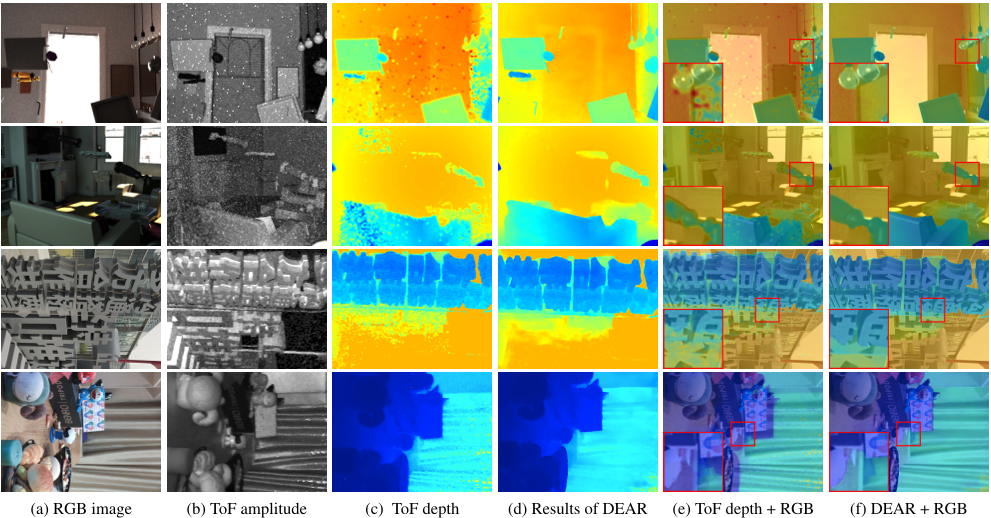

In [ ]:
images = Image.open(dataset_train_json[0]['image']).convert("RGB")
images

In [ ]:
dataset_train = [format_data(sample) for sample in dataset_train_json]

In [ ]:
dataset_train[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data.\nYour task is to process and extract meaningful insights from images, videos, and visual patterns,\nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=991x518>},
   {'type': 'text',
    'text': '<image>\nHow does the DEAR + RGB image compare to the ToF depth + RGB image?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The DEAR + RGB image is sharper and has more detail than the ToF depth + RGB image.'}]}]

### Validation dataset

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_val.json", "r") as f:
    dataset_val_json = json.load(f)

In [ ]:
# dataset_val_json

In [ ]:
dataset_intermediate_val = convert_to_lora_intermediate_dataset(dataset_val_json)
dataset_intermediate_val[0]

{'id': '1705.08868v2',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1705.08868v2/1705.08868v2-Table1-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich objective function resulted in the highest MODE score?'},
  {'from': 'gpt', 'value': 'ADV'}]}

In [ ]:
dataset_validation = [format_data(sample) for sample in dataset_intermediate_val]
dataset_validation[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data.\nYour task is to process and extract meaningful insights from images, videos, and visual patterns,\nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=490x97>},
   {'type': 'text',
    'text': '<image>\nWhich objective function resulted in the highest MODE score?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'ADV'}]}]

### Test dataset

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/test-A/SPIQA_testA.json", "r") as f:
    dataset_test_json = json.load(f)

In [ ]:
dataset_intermediate_test = convert_to_lora_intermediate_dataset(dataset_test_json,image_base_path='/content/spiqa/spiqa_images/SPIQA_testA_Images')
dataset_intermediate_test[0]

{'id': '1611.04684v1',
 'image': '/content/spiqa/spiqa_images/SPIQA_testA_Images/1611.04684v1/1611.04684v1-Table1-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat are the main differences between the educational philosophies of the Bonaparte and Voltaire schools?'},
  {'from': 'gpt',
   'value': 'The Bonaparte school focuses on outdoor physical activities, maneuvers, and strategies, with a specialization in horse riding, lances, and swords. They aim to develop students into good leaders. The Voltaire school, on the other hand, encourages independent thinking and focuses on indoor activities. They aim to instill good moral values and develop students into philosophical thinkers.'}]}

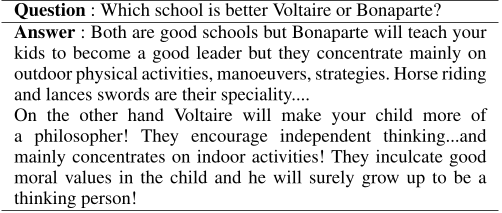

In [ ]:
Image.open('/content/spiqa/spiqa_images/SPIQA_testA_Images/1611.04684v1/1611.04684v1-Table1-1.png').convert("RGB")

In [ ]:
dataset_test = [format_data(sample) for sample in dataset_intermediate_test]
dataset_test[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data.\nYour task is to process and extract meaningful insights from images, videos, and visual patterns,\nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=502x213>},
   {'type': 'text',
    'text': '<image>\nWhat are the main differences between the educational philosophies of the Bonaparte and Voltaire schools?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The Bonaparte school focuses on outdoor physical activities, maneuvers, and strategies, with a specialization in horse riding, lances, and swords. They aim to develop students into good leaders. The Voltaire school, on the other hand, encourages independent thinking and focuses on 

### Length of the datasets

In [ ]:
print(len(dataset_train))
print(len(dataset_validation))
print(len(dataset_test))

2000
2085
666


## Small test before training the model

<image>
What are the main differences between the educational philosophies of the Bonaparte and Voltaire schools?
The Bonaparte school focuses on outdoor physical activities, maneuvers, and strategies, with a specialization in horse riding, lances, and swords. They aim to develop students into good leaders. The Voltaire school, on the other hand, encourages independent thinking and focuses on indoor activities. They aim to instill good moral values and develop students into philosophical thinkers.


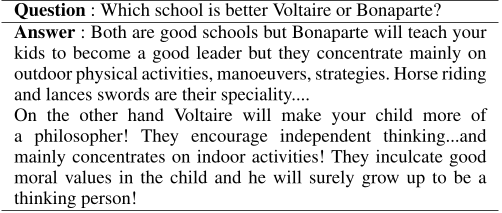

In [ ]:
sample_data = dataset_test[0]
sample_question = dataset_test[0][1]['content'][1]['text']
print(sample_question)
sample_answer = dataset_test[0][2]['content'][0]['text']
print(sample_answer)
sample_image = dataset_test[0][1]['content'][0]['image']
sample_image

## Loading the model

In [18]:
# The model repo is downloaded in to the drive folder
import sys
sys.path.append("/content/drive/MyDrive/FYPIRP_COLAB_DATA/LLaVA")

In [22]:
MODEL_ID = 'llava-hf/llava-1.5-7b-hf'

if device == "cuda":
      bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
      model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        # llm_int8_enable_fp32_cpu_offload=True
    )
else:
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID
    )

# Disable use_cache (IMPORTANT for LoRA/PEFT)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
print(processor.apply_chat_template(messages, tokenize=False))

### Colate Function

In [28]:
# from PIL import Image
def collate_fn(examples):
    # Apply chat template to each example
    prompts = [processor.apply_chat_template(e["messages"], tokenize=False) for e in examples]

    # Load and preprocess images
    images = [Image.open(e["images"][0]).convert("RGB") for e in examples]

    # Tokenize + preprocess image-text pairs
    batch = processor(text=prompts, images=images, return_tensors="pt", padding=True)

    # Mask out padding tokens and unused special tokens from loss
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels
    return batch


In [ ]:
!torchrun --nproc_per_node=1 --master_port=20001 /content/drive/MyDrive/FYPIRP_COLAB_DATA/LLaVA/llava/train/train_mem.py \
    --model_name_or_path liuhaotian/llava-v1.5-7b \
    --version plain \
    --data_path /content/spiqa/train.json \
    --image_folder /content/spiqa/images \
    --vision_tower openai/clip-vit-large-patch14 \
    --mm_projector_type mlp2x_gelu \
    --lora_enable True \
    --lora_r 32 \
    --lora_alpha 64 \
    --output_dir /content/drive/MyDrive/FYPIRP_COLAB_DATA/output/checkpoints/llava-1.5-spiqa-lora \
    --num_train_epochs 2 \
    --per_device_train_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --bf16 True \
    --learning_rate 2e-5 \
    --logging_steps 10 \
    --save_strategy "epoch" \
    --report_to tensorboard


### Configs

In [95]:
# from transformers import BitsAndBytesConfig, LlavaForConditionalGeneration
# import torch

MODEL_ID = 'llava-hf/llava-1.5-7b-hf'

if device == "cuda":
      bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
      model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        # llm_int8_enable_fp32_cpu_offload=True
    )
else:
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID
    )

# Disable use_cache (IMPORTANT for LoRA/PEFT)
model.config.use_cache = False


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

# New Section

In [83]:
import gc
import torch

# Delete model, processor, trainer explicitly
del model
del processor
del trainer

# Collect garbage and empty CUDA cache
gc.collect()
torch.cuda.empty_cache()


In [85]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Allocated: 4.78 GB
Reserved: 19.09 GB


#### Load the model

In [ ]:
# os.chdir("/content/drive/MyDrive/FYPIRP_COLAB_DATA/LLaVA")

In [ ]:
# !pip install -e .

Obtaining file:///content/drive/MyDrive/FYPIRP_COLAB_DATA/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/

In [ ]:
!deepspeed llava/train/train_mem.py \
    --deepspeed scripts/zero2.json \
    --lora_enable True \
    --lora_r 128 \
    --lora_alpha 256 \
    --mm_projector_lr 2e-5 \
    --bits 4 \
    --model_name_or_path /content/LLaVA/llava-v1.5-7b \
    --version llava_llama_2 \
    --data_path /content/dataset/train/dataset.json \
    --validation_data_path /content/dataset/validation/dataset.json \
    --image_folder /content/dataset/images/ \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir /content/LLaVA/llava/checkpoints/llama-2-7b-chat-task-qlora \
    --num_train_epochs 3 \
    --per_device_train_batch_size 2 \
    --per_device_eval_batch_size 2 \
    --gradient_accumulation_steps 8 \
    --evaluation_strategy "epoch" \
    --save_strategy "steps" \
    --save_steps 500 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0.0 \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 10 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

In [ ]:
# Set the prompt and model versions directly in the command
deepspeed /root/LLaVA/llava/train/train_mem.py \
    --deepspeed /root/LLaVA/scripts/zero2.json \
    --lora_enable True \
    --lora_r 128 \
    --lora_alpha 256 \
    --mm_projector_lr 2e-5 \
    --bits 4 \
    --model_name_or_path /root/LLaVA/llava/llava-v1.5-7b \
    --version llava_llama_2 \
    --data_path /root/dataset/train/dataset.json \
    --validation_data_path /root/dataset/validation/dataset.json \
    --image_folder /root/dataset/images/ \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir /root/LLaVA/llava/checkpoints/llama-2-7b-chat-task-qlora \
    --num_train_epochs 500 \
    --per_device_train_batch_size 32 \
    --per_device_eval_batch_size 32 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy “epoch” \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb




SyntaxError: invalid decimal literal (<ipython-input-67-bc7c43fb744c>, line 9)

In [ ]:
processor = LlavaProcessor.from_pretrained(MODEL_ID)
# processor.tokenizer.padding_side = "right"

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

In [ ]:
def text_generator(sample_data):
    # DO NOT use apply_chat_template
    # Take text directly from the dataset
    user_text = sample_data[1]["content"][1]["text"]  # the question with <image> already inside

    print("----- INPUT TEXT ------")
    print(user_text)
    print("------------------------")

    # Check number of <image> tags
    n_images = user_text.count("<image>")
    if n_images != 1:
        raise ValueError(f"Expected exactly 1 <image> in the text, but found {n_images}.")

    # Prepare the corresponding image
    image_input = sample_data[1]["content"][0]["image"]

    # Pass text and image correctly
    inputs = processor(
        text=[user_text],
        images=[image_input],
        return_tensors="pt"
    )
    inputs = inputs.to(device)

    # Generate model outputs
    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )

    # Get the ground truth answer
    actual_answer = sample_data[2]["content"][0]["text"]

    del inputs

    return output_text[0], actual_answer


In [ ]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

----- INPUT TEXT ------
<image>
What are the main differences between the educational philosophies of the Bonaparte and Voltaire schools?
------------------------
Generated Answer: 
What are the main differences between the educational philosophies of the Bonaparte and Voltaire schools?

The main differences between the educational philosophies of the Bonaparte and Voltaire schools lie in their views on the role of education in society. Bonaparte believed that education should focus on practical skills and the development of good citizens, while Voltaire emphasized the importance of critical thinking, individualism, and the pursuit of knowledge. Bonaparte's approach prioritized the development of practical skills and the formation of good citizens, while Voltaire's approach emphasized the importance of critical thinking, individualism, and the pursuit of knowledge.
Actual Answer: The Bonaparte school focuses on outdoor physical activities, maneuvers, and strategies, with a specializati

### LoRA configs

In [24]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules="all-linear",
    modules_to_save=["lm_head", "embed_tokens"],
    bias="none",
    task_type="CAUSAL_LM"
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


Before adapter parameters: 7063427072
trainable params: 309,936,128 || all params: 7,373,363,200 || trainable%: 4.2035


In [ ]:
#  peft_config = LoraConfig(
#     lora_alpha=16,
#     lora_dropout=0.1,
#     r=8,
#     bias="none",
#     target_modules=["q_proj", "v_proj"],
#     task_type="CAUSAL_LM",
# )


Before adapter parameters: 7063427072
trainable params: 4,980,736 || all params: 7,068,407,808 || trainable%: 0.0705


### convert dataset to huggingface format

In [25]:
from datasets import Dataset

In [26]:
# Assume `converted_data` is your 2000-sample list (already formatted correctly)
dataset_ = Dataset.from_list(dataset)


In [27]:
dataset_[0]

{'id': '1911.01655v1',
 'images': ['/content/spiqa/spiqa_images/SPIQA_train_val_Images/1911.01655v1/1911.01655v1-Figure5-1.png'],
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'How does the performance of the different models compare in terms of Peak Signal-to-Noise Ratio?',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'The CNN Best FVD model performs the best, followed by the LSTM Best FVD model, and then the SVG Best FVD model.',
     'type': 'text'}],
   'role': 'assistant'}]}

### Training Arguments

In [29]:
OUTPUT_DIR = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/output/llava-lora-sft"
# from trl import SFTConfig
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    bf16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    logging_steps=10,
    save_strategy="epoch",
    report_to="tensorboard",
    optim="adamw_torch_fused",
    remove_unused_columns=False,
    dataset_kwargs={"skip_prepare_dataset": True}
)

In [ ]:
training_args = SFTConfig(
    output_dir="/content/drive/MyDrive/FYPIRP_COLAB_DATA/output_28_04",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

In [ ]:
collate_sample = [dataset_train[0], dataset_train[1]] # for batch size 2.
print(collate_sample)
def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [example[1]["content"][0]["image"] for example in examples]

    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = batch["input_ids"]

    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())  # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

[[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. \nYour task is to process and extract meaningful insights from images, videos, and visual patterns, \nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=991x518 at 0x7EEA64664650>}, {'type': 'text', 'text': '<image>\nHow does the DEAR + RGB image compare to the ToF depth + RGB image?'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'The DEAR + RGB image is sharper and has more detail than the ToF depth + RGB image.'}]}], [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. \nYour task is to process and extract meaningful insigh

#### Trainer

In [50]:
sample = convert_conversations(dataset[0])  # use the function I gave earlier


KeyError: 'conversations'

In [49]:
prompt = processor.apply_chat_template(sample["messages"], tokenize=False)
print(prompt)

NameError: name 'sample' is not defined

In [33]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_,
    data_collator=collate_fn,
    processing_class=processor,
    peft_config=peft_config
)

trainer.train()
trainer.save_model(OUTPUT_DIR)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,44.151600
20,31.830200
30,20.055700
40,12.508600
50,7.142900
60,3.846700
70,2.191200
80,1.429100
90,1.033300
100,0.787400


Step,Training Loss
10,44.151600
20,31.830200
30,20.055700
40,12.508600
50,7.142900
60,3.846700
70,2.191200
80,1.429100
90,1.033300
100,0.787400


In [ ]:
dataset_validation

Dataset({
    features: [],
    num_rows: 0
})

In [ ]:
dataset_train[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. \nYour task is to process and extract meaningful insights from images, videos, and visual patterns, \nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=991x518>},
   {'type': 'text',
    'text': '<image>\nHow does the DEAR + RGB image compare to the ToF depth + RGB image?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The DEAR + RGB image is sharper and has more detail than the ToF depth + RGB image.'}]}]

In [ ]:
# 1. Preprocess
def flatten_dataset(dataset_train):
  # 1. Flatten your dataset manually first
  cleaned_data_train = []

  for convo in dataset_train:
      # convo is a list of 3 dicts: system, user, assistant
      system_msg = convo[0]
      user_msg = convo[1]
      assistant_msg = convo[2]

      user_text = user_msg['content'][1]['text']          # text after image
      user_image = user_msg['content'][0]['image']         # first image
      assistant_text = assistant_msg['content'][0]['text'] # assistant's reply

      cleaned_data_train.append({
          "text": user_text,
          "image": user_image,
          "labels": assistant_text
      })
      return cleaned_data_train

In [ ]:
flat_train

[{'text': '<image>\nHow does the DEAR + RGB image compare to the ToF depth + RGB image?',
  'image': <PIL.Image.Image image mode=RGB size=991x518>,
  'labels': 'The DEAR + RGB image is sharper and has more detail than the ToF depth + RGB image.'}]

In [ ]:
flat_train = flatten_dataset(dataset_train)
flat_test = flatten_dataset(dataset_test)
flat_validation = flatten_dataset(dataset_validation)
print(len(flat_train))
print(len(flat_test))
print(len(flat_validation))

1
1
1


In [ ]:
# 2. Wrap into Dataset
from datasets import Dataset

dataset_train = Dataset.from_list(faltten_dataset(dataset_train))
dataset_test = Dataset.from_list(faltten_dataset(dataset_test))
dataset_validation = Dataset.from_list(faltten_dataset(dataset_validation))

In [ ]:
dataset_train[0]

IndexError: Invalid key: 0 is out of bounds for size 0

In [ ]:
from datasets import Dataset

# Convert your Python list to a Hugging Face Dataset
dataset_train = Dataset.from_list(dataset_train)
dataset_validation = Dataset.from_list(dataset_validation)
dataset_test = Dataset.from_list(dataset_test)


In [ ]:
def preprocess(example):
    return {
        "text": example[1]["content"][1]["text"],    # user question with <image>
        "image": example[1]["content"][0]["image"],   # user image
        "labels": example[2]["content"][0]["text"]    # assistant's answer
    }
dataset_train = dataset_train.map(preprocess)
dataset_validation = dataset_validation.map(preprocess)

AttributeError: 'list' object has no attribute 'map'

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_validation,
    data_collator=collate_fn,        # you should have a collate_fn that handles images correctly
    peft_config=peft_config,          # LoRA config
    processing_class=processor,       # full processor (not tokenizer only)
    # label_names=["labels"],           # important to avoid warnings
)


StopIteration: 

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train[0:500],
    eval_dataset=dataset_validation[0:500],
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor, #intially processing_class=processor.tokenizer
)

StopIteration: 

In [ ]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


ValueError: Image features and image tokens do not match: tokens: 1152, features 576



---



In [ ]:
# import random

In [ ]:
# output_path = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_sample.json"
# random.shuffle(dataset_train_json)

# with open(output_path, "w") as f:
#     json.dump(dataset_train_json[0:2000], f, indent=2)

# print(f" Sampled train dataset saved to: {output_path}")

 Sampled train dataset saved to: /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_sample.json


## Training arguments defining

## bitsandbytes config

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

### Convert to huggingface dataset

In [ ]:
dataset_train = Dataset.from_list(dataset_train_json[0:2000])

NameError: name 'Dataset' is not defined

## Defining functions for training with optuna

In [ ]:
max_memory = {
    0: "23000MB",  # L4 has 24 GB, leave some headroom
    "cpu": "8GB"
}

def model_init():
    base_model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        max_memory=max_memory
    )

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
    return get_peft_model(base_model, lora_config)

# Search space for Optuna
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [1, 2]),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 3),
    }

def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    inputs["labels"] = inputs["input_ids"]
    return inputs



### Downloading images and and unzipping the folder

In [ ]:
def lot_loss(trainer):
  # If training is interrupted, and you have access to the `trainer` object
  loss_history = trainer.state.log_history

  # Extract steps and loss
  steps = [log['step'] for log in loss_history if 'loss' in log]
  losses = [log['loss'] for log in loss_history if 'loss' in log]

  # Plot
  import matplotlib.pyplot as plt

  plt.plot(steps, losses)
  plt.xlabel("Steps")
  plt.ylabel("Training Loss")
  plt.title("Training Loss Over Time")
  plt.grid(True)
  plt.show()


In [ ]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
class LiveLossPlotCallback(TrainerCallback):
    def __init__(self):
        self.steps = []
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Only plot when there's a loss logged
        if "loss" in logs:
            self.steps.append(state.global_step)
            self.losses.append(logs["loss"])

            # Live plot
            if state.global_step % 50 == 0:
                clear_output(wait=True)
                plt.plot(self.steps, self.losses)
                plt.xlabel("Steps")
                plt.ylabel("Loss")
                plt.title("Training Progress")
                plt.grid(True)
                plt.show()


In [ ]:
# TrainingArguments (will be updated by Optuna trial)
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora-optuna",
    logging_steps=10,
    save_steps=50,
    save_strategy="steps",
    eval_steps=50,
    # evaluation_strategy="steps",
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="wandb",
    fp16=True,
    remove_unused_columns=False,
    save_total_limit=2,
    label_names=["labels"],
)


### Define trainer and Run the optuna search

In [ ]:
#  Define trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset_train,
    data_collator=collate_fn,
)

In [ ]:
try:
    best_run = trainer.hyperparameter_search(
        direction="minimize",
        n_trials=5,  # Keep this low on colab
        hp_space=hp_space,
        compute_objective=lambda metrics: metrics["eval_loss"],
    )

except KeyboardInterrupt:
    print("Interrupted by user! Fetching best trial so far...")

    study = optuna.study.get_all_study_summaries()[0].study_name
    loaded_study = optuna.load_study(study_name=study, storage="sqlite:///optuna.db")
    best_trial = loaded_study.best_trial

    best_run = {
        "trial_id": best_trial.number,
        "loss": best_trial.value,
        "hyperparameters": best_trial.params
    }

print("\n Best Trial:")
print(best_run)


[I 2025-04-24 05:10:08,897] A new study created in memory with name: no-name-cc64c74c-d005-4d94-9cb7-d31ac02c022f


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/grad_norm,▆▅██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁
train/loss,██▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,1.67
train/global_step,1670
train/grad_norm,2.02936
train/learning_rate,0.0
train/loss,7.3899


Step,Training Loss
10,48.851400
20,39.085100
30,24.262400
40,18.941400
50,17.528600
60,16.780200
70,16.313800
80,15.929800
90,15.513000
100,15.364700


Step,Training Loss
10,48.851400
20,39.085100
30,24.262400
40,18.941400
50,17.528600
60,16.780200
70,16.313800
80,15.929800
90,15.513000
100,15.364700


[W 2025-04-24 06:07:25,717] Trial 0 failed with parameters: {'learning_rate': 8.103801367378882e-05, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 4, 'num_train_epochs': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/integrations/integration_utils.py", line 254, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2560, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^

Interrupted by user! Fetching best trial so far...


TypeError: get_all_study_summaries() missing 1 required positional argument: 'storage'

In [ ]:
## Save study and load it
study = optuna.create_study(
    direction="minimize",
    study_name="llava_finetune",
    storage="sqlite:///optuna.db",
    load_if_exists=True
)

best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    compute_objective=lambda metrics: metrics["eval_loss"],
    n_trials=10,
    direction="minimize",
    study=study,
)
loaded_study = optuna.load_study(
    study_name="llava_finetune",
    storage="sqlite:///optuna.db"
)
print("Best trial so far:", loaded_study.best_trial)

# if want to save it to gdrive-
!cp optuna.db /content/drive/MyDrive/optuna_studies/

[I 2025-04-24 06:07:37,124] A new study created in RDB with name: llava_finetune


TypeError: create_study() got an unexpected keyword argument 'study'

In [ ]:
#  Run Optuna search
best_run = trainer.hyperparameter_search(
    direction="minimize",
    n_trials=5,  # Keep this low on Colab
    hp_space=hp_space,
    compute_objective=lambda metrics: metrics["eval_loss"],
)

# Print Best Run
print("Best Trial:")
print(best_run)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-04-24 04:07:14,497] A new study created in memory with name: no-name-7f74d9eb-9265-4999-b5e1-af406d34d609


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,█▁
train/learning_rate,█▅▁
train/loss,█▅▁
train/epoch,0.00091
train/global_step,30
train/grad_norm,8.62687
train/learning_rate,0.0001
train/loss,22.1803


Step,Training Loss
10,24.822900
20,24.763400
30,24.186400
40,23.614100
50,22.942800
60,21.918000
70,20.680300
80,19.897000
90,17.911700
100,16.988300


[W 2025-04-24 05:04:44,526] Trial 0 failed with parameters: {'learning_rate': 1.0343366524739837e-05, 'per_device_train_batch_size': 1, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/integrations/integration_utils.py", line 254, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2560, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^

KeyboardInterrupt: 

In [ ]:
print(best_run)

NameError: name 'best_run' is not defined

training_args TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=50,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_ob

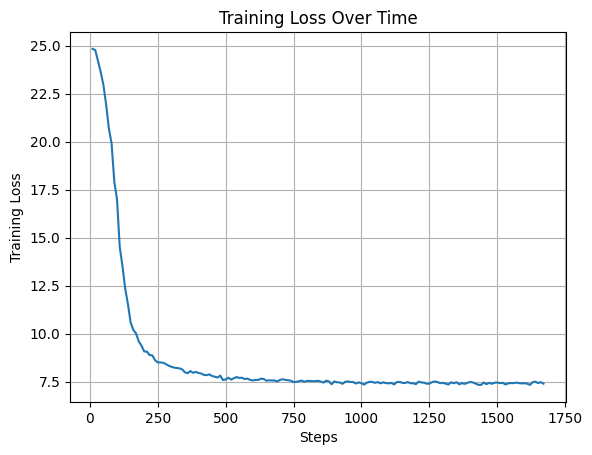

In [ ]:
print('training_args',training_args)
print("LoRA args: ",     '''lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )''')
lot_loss(trainer)

training_args TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=50,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_ob

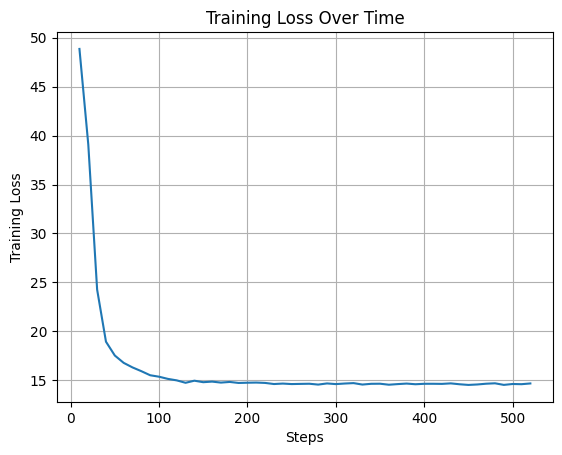

In [ ]:
print('training_args',training_args)
print("LoRA args: ",     '''lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )''')
lot_loss(trainer)

Loss Trend:

Strong initial learning: Loss drops sharply from 24.8 → 10.1 in the first 160 steps.

Gradual refinement: After step 200, loss decreases slowly, fluctuating between ~7.3–8.5.

Convergence: By step 1000, loss stabilizes around 7.3–7.5, suggesting the model is nearing convergence.

Potential Issues:

Fluctuations (e.g., steps 370, 480, 1130) indicate noisy data or a slightly high learning rate.

No further improvement after step 1000—might need early stopping or LR adjustment.

Training Speed:

0.49 it/s is reasonable for LoRA on a single GPU.

## Best hyperparameters to train

In [ ]:
best_args = best_run.hyperparameters

training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora-best",
    learning_rate=best_args["learning_rate"],
    per_device_train_batch_size=best_args["per_device_train_batch_size"],
    gradient_accumulation_steps=best_args["gradient_accumulation_steps"],
    num_train_epochs=best_args["num_train_epochs"],
    logging_steps=10,
    save_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="wandb",
    fp16=True,
    remove_unused_columns=False,
    save_total_limit=2,
    label_names=["labels"],
)

final_trainer = Trainer(
    model=model_init(),
    args=training_args,
    train_dataset=dataset_train,
    data_collator=collate_fn,
)
final_trainer.train()


NameError: name 'best_run' is not defined

End of clean code



---



In [ ]:
# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [ ]:
# 4. Unzip relevant data
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json", "r") as f:
    converted = json.load(f)

In [ ]:
old_prefix = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"
new_prefix = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images"


# Update paths
for d in converted:
    if d['image'].startswith(old_prefix):
        d['image'] = d['image'].replace(old_prefix, new_prefix, 1)

# Preview result
for d in converted[:2]:
    print(d['image'])

/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png
/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Table1-1.png


In [ ]:
import os

def find_file(root_dir, filename):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    if filename in filenames:
      return os.path.join(dirpath, filename)
  return None

path = find_file("/content/", "1612.01810v3-Figure6-1.png")
print(path)

/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png


In [ ]:
dataset = Dataset.from_list(converted)

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    use_fast = True
)

In [ ]:
dataset[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"  # 7B for Colab T4
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",

)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
lora_config = LoraConfig(
    r=8,  # Rank
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Key attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # ~0.1% params

trainable params: 4,980,736 || all params: 7,068,407,808 || trainable%: 0.0705


In [ ]:
def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    # Enable loss computation!
    inputs["labels"] = inputs["input_ids"].clone()
    return inputs

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"],  # Specifies that "labels" will be the label input in the model
    # evaluation_strategy="steps",  # Evaluate the model every `eval_steps` steps
    save_strategy="steps",  # Save model weights every `save_steps` steps
    eval_steps=50,  # Evaluate the model every 50 steps
    # load_best_model_at_end=True,  # Automatically load the best model based on evaluation
    metric_for_best_model="loss",  # Track loss to determine the best model
    greater_is_better=False,  # We want a lower loss, so False is correct
    save_total_limit=2,  # Keep only the 2 latest saved models
)

print(training_args)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=50,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,
fp

In [ ]:
!pip install --upgrade --no-cache-dir transformers

In [ ]:
from transformers import TrainingArguments, Trainer
import wandb

wandb.login()  # only once per machine or runtime
wandb.init(project="my-llava-finetune")  # optional, but useful

# Define training arguments
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"],  # Specifies that "labels" will be the label input in the model
    # evaluation_strategy="steps",  # Evaluate the model every `eval_steps` steps
    save_strategy="steps",  # Save model weights every `save_steps` steps
    eval_steps=50,  # Evaluate the model every 50 steps
    # load_best_model_at_end=True,  # Automatically load the best model based on evaluation
    metric_for_best_model="loss",  # Track loss to determine the best model
    greater_is_better=False,  # We want a lower loss, so False is correct
    save_total_limit=2,  # Keep only the 2 latest saved models
)
print(training_args)

# Initialize trainer with the defined arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
    # eval_dataset=val_dataset,  # Uncomment if you have a validation dataset
)

# Start training
trainer.train()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Step,Training Loss
10,48.233300
20,29.462300
30,18.095600
40,16.634200
50,15.897400
60,15.478000
70,15.106800
80,14.984800
90,14.865500
100,14.814100


KeyboardInterrupt: 

Training Loss Trend:

The loss starts very high (48.23) but drops rapidly in the first few steps, indicating the model is quickly learning from the initial data.

By step 30, the loss is down to ~18.09, showing good early progress.

After step 50, the loss stabilizes around 14.6–15.8, suggesting the model is now fine-tuning rather than making big leaps.

Convergence Behavior:

The loss is still decreasing slowly (14.81 → 14.69 between steps 100–160), meaning the model is still improving, but gains are marginal.

There’s some fluctuation (e.g., 14.69 → 14.75 around step 150), which could be due to noisy data or a high learning rate.

Training Speed:

0.25 iterations/sec is relatively slow—this could be due to hardware constraints (e.g., a single GPU) or a large batch size.

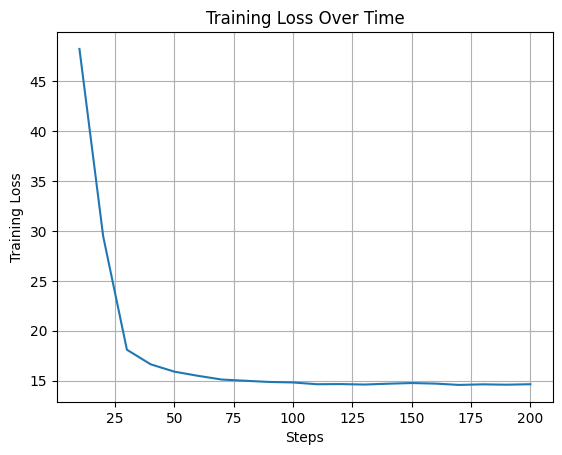

In [ ]:
def lot_loss(trainer):
  # If training is interrupted, and you have access to the `trainer` object
  loss_history = trainer.state.log_history

  # Extract steps and loss
  steps = [log['step'] for log in loss_history if 'loss' in log]
  losses = [log['loss'] for log in loss_history if 'loss' in log]

  # Plot
  import matplotlib.pyplot as plt

  plt.plot(steps, losses)
  plt.xlabel("Steps")
  plt.ylabel("Training Loss")
  plt.title("Training Loss Over Time")
  plt.grid(True)
  plt.show()


In [ ]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
class LiveLossPlotCallback(TrainerCallback):
    def __init__(self):
        self.steps = []
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Only plot when there's a loss logged
        if "loss" in logs:
            self.steps.append(state.global_step)
            self.losses.append(logs["loss"])

            # Live plot
            if state.global_step % 50 == 0:
                clear_output(wait=True)
                plt.plot(self.steps, self.losses)
                plt.xlabel("Steps")
                plt.ylabel("Loss")
                plt.title("Training Progress")
                plt.grid(True)
                plt.show()


NameError: name 'TrainerCallback' is not defined

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
    callbacks=[LiveLossPlotCallback()],
)

In [ ]:
# Run this FIRST (before any imports)
!pip install --force-reinstall numpy==1.23.5
!pip install --force-reinstall torch==2.0.1 torchvision==0.15.2 transformers==4.30.2
!pip install --force-reinstall datasets==2.13.1 peft==0.4.0 accelerate==0.20.3
!pip install --force-reinstall bitsandbytes==0.40.2 Pillow==9.5.0
# !pip install -q git+https://github.com/haotian-liu/LLaVA.git@main  # LLaVA main branch

# Verify installations
!pip list | grep -E "torch|transformers|datasets|peft|bitsandbytes|numpy"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 whi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.7 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 7.2 MB/s eta 0:00:00
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-ma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 116.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.6.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


bitsandbytes                          0.40.2
datasets                              2.13.1
numpy                                 2.2.5
peft                                  0.4.0
sentence-transformers                 3.4.1
tensorflow-datasets                   4.9.8
torch                                 2.6.0
torchaudio                            2.6.0+cu124
torchsummary                          1.5.1
torchvision                           0.15.2
transformers                          4.51.3
vega-datasets                         0.9.0


In [ ]:
import numpy as np
print(np.__version__)  # Must show '1.23.5'
assert hasattr(np, 'dtype')  # Check critical attribute

2.2.5


In [ ]:
!apt-get update
!apt-get install cuda-toolkit-11-8
import os
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11/lib64"
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11.8/lib64"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,150 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/mai

In [ ]:
!pip install datasets==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.13.1
    Uninstalling datasets-2.13.1:
      Successfully uninstalled datasets-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-qn7h257w
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-qn7h257w
  Resolved https://github.com/huggingface/transformers to commit 4f9893cbbc556c7c27b42bdc64fc271f7b1a0218
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.52.0.dev0-py3-none-any.whl size=11450530 sha256=156687f325c1da94f1b3c041d7bda89ca6a5a647ecc36e5cea40b226c1244881
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3biscnw/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully 

In [ ]:
! pip install -U transformers

In [ ]:
# from transformers import Qwen2VLForConditionalGeneration
# from transformers import Qwen2VLProcessor
from transformers import BitsAndBytesConfig

ImportError: cannot import name 'is_jinja_available' from 'transformers.utils.import_utils' (/usr/local/lib/python3.11/dist-packages/transformers/utils/import_utils.py)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch



AttributeError: module 'numpy' has no attribute 'dtypes'

# SPIQA dataset

In [ ]:
from huggingface_hub import snapshot_download

# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [ ]:
# 4. Unzip relevant data
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# 5. Load and convert SPIQA_train.json to LLaVA format
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_train.json", "r") as f:
    spiqa_data = json.load(f)


In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_val.json", "r") as f:
    spiqa_val_data = json.load(f)

In [ ]:
spiqa_test_data_df = pd.read_csv("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa.csv")

In [ ]:
spiqa_test_data_df.head(3)

,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...
1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...
2,spiqa_2,1603.00286v5,How does Figure 1 in the paper illustrate the ...,"\n\nIn 2-D division, there may be unallocated...",1603.00286v5.pdf,"['1603.00286v5.pdf', '1705.07164v8.pdf', '1811...",\n\nFigure 1 shows an example of a 2-D cake w...,1603.00286v5-Figure1-1.png,Redividing the Cake,The paper considers fair allocation of resourc...,"Fig. 1 With geometric constraints, an efficien...",\n\nWhy does the author state that there is a...


In [ ]:
spiqa_data['2307.11618v1'].keys()

dict_keys(['paper_id', 'all_figures', 'qa'])

In [ ]:
spiqa_data['2307.11618v1']['qa'][0]

{'question': 'Which method performs the best on the DomainNet dataset with a labeling budget of 5k?',
 'answer': 'DiaNA (Ours)',
 'explanation': 'The table shows the accuracy of different methods on the DomainNet dataset with different labeling budgets. DiaNA (Ours) achieves the highest accuracy of 57.8% with a labeling budget of 5k.',
 'reference': '2307.11618v1-Table1-1.png'}

In [ ]:
spiqa_data['2307.11618v1']['all_figures'].keys()

dict_keys(['2307.11618v1-Table1-1.png', '2307.11618v1-Table2-1.png', '2307.11618v1-Figure2-1.png', '2307.11618v1-Table5-1.png', '2307.11618v1-Figure6-1.png', '2307.11618v1-Figure7-1.png', '2307.11618v1-Figure4-1.png', '2307.11618v1-Table3-1.png', '2307.11618v1-Figure3-1.png', '2307.11618v1-Figure5-1.png', '2307.11618v1-Table4-1.png'])

In [ ]:
spiqa_data['2307.11618v1']['all_figures']['2307.11618v1-Table1-1.png']

{'caption': ' Comparison results (Accuracy: %) on DomainNet with 1k, 2k and 5k labeling budgets. “Random” and “CONF” correspond to the classic AL approaches “Random Sampling” and “Least-Confidence Sampling”.',
 'content_type': 'table',
 'figure_type': 'table'}

In [ ]:
# import json
# import os

# # Load SPIQA data (update path as needed)
# with open("/content/spiqa/train_val/SPIQA_train.json", "r") as f:
#     spiqa_data = json.load(f)
def convert_to_lora_dataset(spiqa_data):
  converted = []
  image_base_path = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"  # Where the images were extracted

  # Iterate through each paper
  for paper_id, paper in spiqa_data.items():
      figures = paper.get("all_figures", {})
      qa_pairs = paper.get("qa", [])

      # print("Nu of qa pairs:", (qa_pairs))

      for qa in qa_pairs:
          ref_img = qa.get("reference")
          question = qa.get("question")
          answer = qa.get("answer")

          if not ref_img or ref_img not in figures:
              continue

          image_path = os.path.join(image_base_path, paper_id, ref_img)
          if not os.path.exists(image_path):
            # print('path does not exist', image_path)
            continue

          # Add to LLaVA-style format
          converted.append({
              "id": paper_id,
              "image": image_path,
              "conversations": [
                  {
                      "from": "human",
                      "value": f"<image>\n{question}"
                  },
                  {
                      "from": "gpt",
                      "value": answer
                  }
              ]
          })
  return converted


In [ ]:
import os

def find_file(root_dir, filename):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    if filename in filenames:
      return os.path.join(dirpath, filename)
  return None

path = find_file("/content", "2310.15484v1-Table5-1.png")

In [ ]:
path

'/content/spiqa/spiqa_images/SPIQA_train_val_Images/2310.15484v1/2310.15484v1-Table5-1.png'

In [ ]:
len(converted)

262524

In [ ]:
converted_val = convert_to_lora_dataset(spiqa_val_data)

In [ ]:
converted_val[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
converted_test_list = []
df = spiqa_test_data_df.copy()

for _, row in df.iterrows():
    paper_id = row['doc_id']
    image_path = "/content/spiqa/spiqa_images/SPIQA_train_val_Images/"+row['reference_figure']  # or some logic to resolve full image path
    question = row['old_question']
    answer = row['answer']

    converted_test_list.append({
        "id": paper_id,
        "image": image_path,
        "conversations": [
            {
                "from": "human",
                "value": f"<image>\n{question}"
            },
            {
                "from": "gpt",
                "value": answer
            }
        ]
    })

# Optional: print or save to JSON
import json
with open('/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_test_converted.json', 'w') as f:
    json.dump(converted_test_list, f, indent=2)


In [ ]:
output_path = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json"
with open(output_path, "w") as f:
    json.dump(converted, f, indent=2)

print(f" Converted dataset saved to: {output_path}")

 Converted dataset saved to: /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json


In [ ]:
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json", "r") as f:
    converted_train = json.load(f)

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_test_converted.json", "r") as f:
    converted_test = json.load(f)

In [ ]:
converted_val = convert_to_lora_dataset(spiqa_val_data)

In [ ]:
converted_train[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
converted_val[0]

{'id': '1705.08868v2',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1705.08868v2/1705.08868v2-Table1-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich objective function resulted in the highest MODE score?'},
  {'from': 'gpt', 'value': 'ADV'}]}

In [ ]:
converted_test[0]

{'id': '1805.01216v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1805.01216v3-Figure9-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nHow does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?'},
  {'from': 'gpt',
   'value': ' \n\nThe pre-processed SMD Navigate data combines all the properties (such as distance, address) of a point of interest (POI) into a single subject with the object being "poi". The original data had separate entries for each property. '}]}

In [ ]:
!pip3 install bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.13.1
    Uninstalling datasets-2.13.1:
      Successfully uninstalled datasets-2.13.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 

In [ ]:
import numpy as np
import sys

# Fix for numpy.dtypes missing
if not hasattr(np, 'dtypes'):
    np.dtypes = np._DTypeMeta
    sys.modules['numpy.dtypes'] = np.dtypes

# Now import transformers
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# Save your file to Drive
!cp -r /content/spiqa/ /content/drive/MyDrive/
# Optionally copy saved files back
!cp -r /content/drive/MyDrive/spiqa/ /content/spiqa/

In [ ]:
!python -m bitsandbytes

False

===================================BUG REPORT===================================
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http')

In [ ]:
import torch
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import json
from PIL import Image

False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-l4-s-2oss8z7urz1cx --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_required=true '), PosixPath('--logtostderr --listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=htt

/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/__init__.py:22 in <module>                          │
│                                                                                                  │
│   19                                                                                             │
│   20 __version__ = "0.4.0"                                                                       │
│   21                                                                                             │
│ ❱ 22 from .auto import (                                                                         │
│   23 │   AutoPeftModel,                                                                          │
│   24 │   AutoPeftModelForCausalLM,                                                               │
│   25 │   AutoPeftModelForSequenceClassification,                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/auto.py:30 in <module>                              │
│                                                                                                  │
│    27 │   AutoModelForTokenClassification,                                                       │
│    28 )                                                                                          │
│    29                                                                                            │
│ ❱  30 from .mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING                                      │
│    31 from .peft_model import (                                                                  │
│    32 │   PeftModel,                                                                             │
│    33 │   PeftModelForCausalLM,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/mapping.py:20 in <module>                           │
│                                                                                                  │
│   17                                                                                             │
│   18 from typing import TYPE_CHECKING, Any, Dict                                                 │
│   19                                                                                             │
│ ❱ 20 from .peft_model import (                                                                   │
│   21 │   PeftModel,                                                                              │
│   22 │   PeftModelForCausalLM,                                                                   │
│   23 │   PeftModelForFeatureExtraction,                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/peft_model.py:39 in <module>                        │
│                                                                                                  │
│     36 from transformers.utils import PushToHubMixin                                             │
│     37                                                                                           │
│     38 from . import __version__                                                                 │
│ ❱   39 from .tuners import (                                                                     │
│     40 │   AdaLoraModel,                                   

In [ ]:
import pandas as pd

In [ ]:
#  SPIQA to LLaVA LoRA Fine-Tuning Pipeline (Colab Ready)
from google.colab import drive

# Disconnect any existing mounts (optional)
!fusermount -u /content/drive

# Mount the secondary Google Drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [ ]:
# 2. Install required libraries
! datasets huggingface_hub
# !git clone https://github.com/haotian-liu/LLaVA.git
# %cd LLaVA
# !pip install -e .

/bin/bash: line 1: datasets: command not found


In [ ]:
#  3. Download SPIQA dataset from Hugging Face
from huggingface_hub import snapshot_download
# snapshot_download(repo_id="google/spiqa", repo_type="dataset", local_dir='/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa')

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/8.60k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

SPIQA_testA.json:   0%|          | 0.00/778k [00:00<?, ?B/s]

SPIQA_testA_Images_224px.zip:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

SPIQA_train_val_test-A_raw_tex.zip:   0%|          | 0.00/440M [00:00<?, ?B/s]

(…)rain_val_test-A_extracted_paragraphs.zip:   0%|          | 0.00/321M [00:00<?, ?B/s]

SPIQA_testA_Images.zip:   0%|          | 0.00/121M [00:00<?, ?B/s]

SPIQA_testB.json:   0%|          | 0.00/3.96M [00:00<?, ?B/s]

SPIQA_testB_Images.zip:   0%|          | 0.00/196M [00:00<?, ?B/s]

example.json:   0%|          | 0.00/103 [00:00<?, ?B/s]

SPIQA_testB_Images_224px.zip:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

SPIQA_testC.json:   0%|          | 0.00/9.29M [00:00<?, ?B/s]

SPIQA_testC_Images.zip:   0%|          | 0.00/112M [00:00<?, ?B/s]

SPIQA_testC_Images_224px.zip:   0%|          | 0.00/63.3M [00:00<?, ?B/s]

SPIQA_train.json:   0%|          | 0.00/209M [00:00<?, ?B/s]

testA_data_viewer.json:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:752: UserWarning: Not enough free disk space to download the file. The expected file size is: 32023.84 MB. The target location /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/.cache/huggingface/download/train_val only has 15717.48 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:752: UserWarning: Not enough free disk space to download the file. The expected file size is: 32023.84 MB. The target location /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val only has 15717.48 MB free disk space.
  warnings.warn(


SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

SPIQA_val.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

'/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa'



---



In [ ]:
old_prefix = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"
new_prefix = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images"


# Update paths
for d in converted:
    if d['image'].startswith(old_prefix):
        d['image'] = d['image'].replace(old_prefix, new_prefix, 1)

# Preview result
for d in converted[:2]:
    print(d['image'])

/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png
/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Table1-1.png




---



##  Create a Hugging Face Dataset
Convert the processed data into a dataset for training:

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5  # Version known to work with datasets
!pip install --upgrade datasets

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 112.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
chex

^C


In [ ]:
from datasets import Dataset


In [ ]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_list(converted)

## Custom Data Collector for LLaVa

In [ ]:
from PIL import Image
from transformers import default_data_collator


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:

def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = []
    for item in batch:
        # Extract human/GPT turns
        human_turn = item["conversations"][0]["value"]  # "<image>\nQuestion"
        gpt_turn = item["conversations"][1]["value"]     # "Answer"
        # Format for LLaVA (USER: <image>\nQuestion ASSISTANT: Answer)
        text = f"USER: {human_turn} ASSISTANT: {gpt_turn}"
        texts.append(text)

    # Process images and texts together
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    return inputs

# Example batch
batch = [dataset[0], dataset[1]]
collate_fn(batch)  # Test if it works



---



In [ ]:
# ====== 1. Load Model (4-bit quantized) ======
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "llava-hf/llava-1.5-7b-hf"
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

In [ ]:
# ====== 2. Apply LoRA ======
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

In [ ]:
# ====== 3. Load Your JSON Data ======
with open("spiqa_converted.json", "r") as f:
    data = json.load(f)  # Your formatted data

dataset = load_dataset("json", data_files={"train": "spiqa_converted.json"})["train"]

In [ ]:
# ====== 4. Data Collator ======
def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    return inputs

In [ ]:
# ====== 5. Training ======
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=5,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
)

trainer.train()

In [ ]:
# ====== 6. Save Model ======
model.save_pretrained("./llava-spiqa-lora")

In [ ]:
# Key Stability Features
# Version Locking: All critical libraries pinned to known stable versions.

# 4-bit Quantization: Reduces memory usage for Colab's T4 GPU.

# New code using the same dataset

In [ ]:
# Step 1: Install required packages (same as before)
!pip install -q bitsandbytes accelerate transformers==4.35.0 peft==0.6.0
!pip install -q git+https://github.com/haotian-liu/LLaVA.git

In [96]:
# Step 2: Check bfloat16 availability
import torch
print(f"bfloat16 supported: {torch.cuda.is_bf16_supported()}")


bfloat16 supported: True


In [103]:
# Step 3: Configure quantization with bfloat16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # Changed to bfloat16
)

# Step 4: Load model with bfloat16
model_name = "llava-hf/llava-1.5-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

processor = AutoProcessor.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16  # Added for bfloat16 support
)

In [108]:
# del model
# del tokenizer
# del bnb_config

In [105]:
# Rest of the LoRA config remains the same
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(processor, lora_config)

AttributeError: 'LlavaProcessor' object has no attribute 'modules'

In [98]:
# Rest of the LoRA config remains the same
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

# Step 5: Update training arguments for bfloat16
training_args = TrainingArguments(
    output_dir="./llava-lora-finetuned-bf16",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    warmup_steps=100,
    max_steps=1000,
    learning_rate=2e-4,
    bf16=True,  # Changed from fp16 to bf16
    logging_steps=10,
    save_steps=200,
    save_total_limit=2,
    report_to="none",
    gradient_checkpointing=True,  # Recommended with bfloat16
)

# Rest of the code remains the same...

ValueError: Unrecognized configuration class <class 'transformers.models.llava.configuration_llava.LlavaConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, Data2VecTextConfig, DbrxConfig, DeepseekV3Config, DiffLlamaConfig, ElectraConfig, Emu3Config, ErnieConfig, FalconConfig, FalconMambaConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, GitConfig, GlmConfig, Glm4Config, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GPTJConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeSharedConfig, HeliumConfig, JambaConfig, JetMoeConfig, LlamaConfig, Llama4Config, Llama4TextConfig, MambaConfig, Mamba2Config, MarianConfig, MBartConfig, MegaConfig, MegatronBertConfig, MistralConfig, MixtralConfig, MllamaConfig, MoshiConfig, MptConfig, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NemotronConfig, OlmoConfig, Olmo2Config, OlmoeConfig, OpenLlamaConfig, OpenAIGPTConfig, OPTConfig, PegasusConfig, PersimmonConfig, PhiConfig, Phi3Config, Phi4MultimodalConfig, PhimoeConfig, PLBartConfig, ProphetNetConfig, QDQBertConfig, Qwen2Config, Qwen2MoeConfig, Qwen3Config, Qwen3MoeConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, Speech2Text2Config, StableLmConfig, Starcoder2Config, TransfoXLConfig, TrOCRConfig, WhisperConfig, XGLMConfig, XLMConfig, XLMProphetNetConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, XmodConfig, ZambaConfig, Zamba2Config.